# COMPARACIONES ENTRE ENFOQUES

In [ ]:
import pandas as pd
from sentence_transformers import SentenceTransformer, util

from nltk.metrics.distance import edit_distance
from nltk import download
download('punkt')

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.font_manager as fm

from nltk.metrics.distance import edit_distance

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


## Métricas

In [ ]:
def normalizar_predicado(p):
    return p.replace("_", " ").lower().strip()

In [ ]:
def evaluate_structural_similarity_ST(baseline_path, gold_path, threshold=0.8, verbose=False):
    model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

    def load_graph(filepath):
        df = pd.read_csv(filepath, sep=';')
        df['predicado'] = df['predicado'].apply(normalizar_predicado)
        nodes = set(df['sujeto']).union(df['objeto'])
        edges = set([tuple(x) for x in df[['sujeto', 'predicado', 'objeto']].values])
        return df, nodes, edges

    def map_entities(pred_entities, gold_entities, model, threshold=0.8):
        pred_list = list(pred_entities)
        gold_list = list(gold_entities)
        pred_emb = model.encode(pred_list, convert_to_tensor=True)
        gold_emb = model.encode(gold_list, convert_to_tensor=True)
        sim_matrix = util.pytorch_cos_sim(pred_emb, gold_emb)
        mapping = {}
        matches = []
        used_gold_nodes = set()
        for i, sims in enumerate(sim_matrix):
            best_score, best_j = sims.max(0)
            if best_score >= threshold:
                pred_term = pred_list[i]
                gold_term = gold_list[best_j.item()]
                if gold_term not in used_gold_nodes:
                    mapping[pred_term] = gold_term
                    used_gold_nodes.add(gold_term)
                    matches.append((pred_term, gold_term, float(best_score)))
                else:
                    mapping[pred_term] = pred_term
            else:
                mapping[pred_list[i]] = pred_list[i]
        return mapping, matches

    def map_edges(pred_edges, gold_edges, model, entity_mapping, threshold=0.8):
        mapped_edges = set()
        gold_edge_list = list(gold_edges)
        matches = []
        used_gold_edges = set()
        for s, p, o in pred_edges:
            s_m = entity_mapping.get(s, s)
            o_m = entity_mapping.get(o, o)
            p_emb = model.encode(p, convert_to_tensor=True)
            found = False
            for gold_s, gold_p, gold_o in gold_edge_list:
                if (gold_s, gold_p, gold_o) in used_gold_edges:
                    continue
                if entity_mapping.get(gold_s, gold_s) != s_m:
                    continue
                if entity_mapping.get(gold_o, gold_o) != o_m:
                    continue
                gold_p_emb = model.encode(gold_p, convert_to_tensor=True)
                sim = util.pytorch_cos_sim(p_emb, gold_p_emb).item()
                if sim >= threshold:
                    mapped_edges.add((s_m, gold_p, o_m))
                    used_gold_edges.add((gold_s, gold_p, gold_o))
                    matches.append(((s, p, o), (gold_s, gold_p, gold_o), float(sim)))
                    found = True
                    break
            if not found:
                mapped_edges.add((s_m, p, o_m))
        return mapped_edges, matches

    df_pred, nodes_pred, edges_pred = load_graph(baseline_path)
    df_gold, nodes_gold, edges_gold = load_graph(gold_path)

    if verbose:
        print("📥 Mapeando nodos...")

    node_mapping, node_matches = map_entities(nodes_pred, nodes_gold, model, threshold)

    if verbose:
        print("📥 Mapeando aristas...")

    mapped_edges, edge_matches = map_edges(edges_pred, edges_gold, model, node_mapping, threshold)
    mapped_nodes = {node_mapping[n] for n in nodes_pred}

    nodes_pred_set = set(mapped_nodes)
    nodes_gold_set = set(nodes_gold)
    edges_pred_set = set(mapped_edges)
    edges_gold_set = set(edges_gold)

    node_inter = nodes_pred_set & nodes_gold_set
    edge_inter = edges_pred_set & edges_gold_set
    node_union = nodes_pred_set | nodes_gold_set
    edge_union = edges_pred_set | edges_gold_set

    similarity = (len(node_inter) + len(edge_inter)) / (len(node_union) + len(edge_union)) if (len(node_union) + len(edge_union)) > 0 else 0.0

    if verbose:
        print("\n✅ Nodos mapeados (pred → gold):")
        for pred, gold, score in node_matches:
            print(f"  {pred} → {gold} (sim={score:.4f})")

        print("\n✅ Aristas mapeadas (pred → gold):")
        for pred_triple, gold_triple, score in edge_matches:
            print(f"  {pred_triple} → {gold_triple} (sim={score:.4f})")

        print(f"\n🧠 Nodos en común ({len(node_inter)}):")
        for n in node_inter:
            print(f"  ✔ {n}")

        print(f"\n➖ Nodos solo en pred ({len(nodes_pred_set - nodes_gold_set)}):")
        for n in nodes_pred_set - nodes_gold_set:
            print(f"  ✖ {n}")

        print(f"\n➖ Nodos solo en gold ({len(nodes_gold_set - nodes_pred_set)}):")
        for n in nodes_gold_set - nodes_pred_set:
            print(f"  ✖ {n}")

        print(f"\n🔗 Aristas en común ({len(edge_inter)}):")
        for e in edge_inter:
            print(f"  ✔ {e}")

        print(f"\n➖ Aristas solo en pred ({len(edges_pred_set - edges_gold_set)}):")
        for e in edges_pred_set - edges_gold_set:
            print(f"  ✖ {e}")

        print(f"\n➖ Aristas solo en gold ({len(edges_gold_set - edges_pred_set)}):")
        for e in edges_gold_set - edges_pred_set:
            print(f"  ✖ {e}")

        print(f"\n📊 Similitud estructural final: {similarity:.4f}")

    return {
      "nodos_en_comun": len(node_inter),
      "aristas_en_comun": len(edge_inter),
      "nodos_totales": len(node_union),
      "aristas_totales": len(edge_union),
      "similitud_estructural": similarity,
      "nodos_pred": nodes_pred_set,
      "nodos_gold": nodes_gold_set,
      "nodos_match": node_inter,
      "aristas_pred": edges_pred_set,
      "aristas_gold": edges_gold_set,
      "aristas_match": edge_inter,
  }

In [ ]:
def evaluate_structural_similarity_levenshtein(baseline_path, gold_path, max_distance=2, verbose=False):
    def load_graph(filepath):
        df = pd.read_csv(filepath, sep=';')
        df['predicado'] = df['predicado'].apply(normalizar_predicado)
        nodes = set(df['sujeto']).union(df['objeto'])
        edges = set([tuple(x) for x in df[['sujeto', 'predicado', 'objeto']].values])
        return df, nodes, edges

    def map_entities(pred_entities, gold_entities, max_distance):
        mapping = {}
        matches = []
        used_gold = set()
        for pred in pred_entities:
            best_match = pred
            best_score = float('inf')
            for gold in gold_entities:
                dist = edit_distance(pred.lower(), gold.lower())
                if dist <= max_distance and dist < best_score and gold not in used_gold:
                    best_match = gold
                    best_score = dist
            mapping[pred] = best_match
            if best_match != pred:
                used_gold.add(best_match)
                matches.append((pred, best_match, best_score))
        return mapping, matches

    def map_edges(pred_edges, gold_edges, entity_mapping, max_distance):
        mapped_edges = set()
        used_gold_edges = set()
        matches = []
        for s, p, o in pred_edges:
            s_m = entity_mapping.get(s, s)
            o_m = entity_mapping.get(o, o)
            found = False
            for gs, gp, go in gold_edges:
                if gs != s_m or go != o_m or (gs, gp, go) in used_gold_edges:
                    continue
                dist = edit_distance(p.lower(), gp.lower())
                if dist <= max_distance:
                    mapped_edges.add((s_m, gp, o_m))
                    used_gold_edges.add((gs, gp, go))
                    matches.append(((s, p, o), (gs, gp, go), dist))
                    found = True
                    break
            if not found:
                mapped_edges.add((s_m, p, o_m))
        return mapped_edges, matches

    df_pred, nodes_pred, edges_pred = load_graph(baseline_path)
    df_gold, nodes_gold, edges_gold = load_graph(gold_path)

    if verbose:
        print("📥 Mapeando nodos...")

    node_mapping, node_matches = map_entities(nodes_pred, nodes_gold, max_distance)

    if verbose:
        print("📥 Mapeando aristas...")

    mapped_edges, edge_matches = map_edges(edges_pred, edges_gold, node_mapping, max_distance)
    mapped_nodes = {node_mapping[n] for n in nodes_pred}

    nodes_pred_set = set(mapped_nodes)
    nodes_gold_set = set(nodes_gold)
    edges_pred_set = set(mapped_edges)
    edges_gold_set = set(edges_gold)

    node_inter = nodes_pred_set & nodes_gold_set
    edge_inter = edges_pred_set & edges_gold_set
    node_union = nodes_pred_set | nodes_gold_set
    edge_union = edges_pred_set | edges_gold_set

    similarity = (len(node_inter) + len(edge_inter)) / (len(node_union) + len(edge_union)) if (len(node_union) + len(edge_union)) > 0 else 0.0

    if verbose:
        print("\n✅ Nodos mapeados (pred → gold):")
        for pred, gold, dist in node_matches:
            print(f"  {pred} → {gold} (dist={dist})")

        print("\n✅ Aristas mapeadas (pred → gold):")
        for pred_triple, gold_triple, dist in edge_matches:
            print(f"  {pred_triple} → {gold_triple} (dist={dist})")

        print(f"\n🧠 Nodos en común ({len(node_inter)}):")
        for n in node_inter:
            print(f"  ✔ {n}")

        print(f"\n➖ Nodos solo en pred ({len(nodes_pred_set - nodes_gold_set)}):")
        for n in nodes_pred_set - nodes_gold_set:
            print(f"  ✖ {n}")

        print(f"\n➖ Nodos solo en gold ({len(nodes_gold_set - nodes_pred_set)}):")
        for n in nodes_gold_set - nodes_pred_set:
            print(f"  ✖ {n}")

        print(f"\n🔗 Aristas en común ({len(edge_inter)}):")
        for e in edge_inter:
            print(f"  ✔ {e}")

        print(f"\n➖ Aristas solo en pred ({len(edges_pred_set - edges_gold_set)}):")
        for e in edges_pred_set - edges_gold_set:
            print(f"  ✖ {e}")

        print(f"\n➖ Aristas solo en gold ({len(edges_gold_set - edges_pred_set)}):")
        for e in edges_gold_set - edges_pred_set:
            print(f"  ✖ {e}")

        print(f"\n📊 Similitud estructural final: {similarity:.4f}")

    return {
      "nodos_en_comun": len(node_inter),
      "aristas_en_comun": len(edge_inter),
      "nodos_totales": len(node_union),
      "aristas_totales": len(edge_union),
      "similitud_estructural": similarity,
      "nodos_pred": nodes_pred_set,
      "nodos_gold": nodes_gold_set,
      "nodos_match": node_inter,
      "aristas_pred": edges_pred_set,
      "aristas_gold": edges_gold_set,
      "aristas_match": edge_inter,
  }

In [ ]:
def calculate_accuracy_ST(gold_path, generated_path, threshold=0.8):
    results = evaluate_structural_similarity_ST(generated_path, gold_path, threshold)
    edge_accuracy = len(results["aristas_match"]) / len(results["aristas_pred"]) if results["aristas_pred"] else 0.0
    node_accuracy = len(results["nodos_match"]) / len(results["nodos_pred"]) if results["nodos_pred"] else 0.0
    return (edge_accuracy + node_accuracy) / 2

def calculate_recall_ST(gold_path, generated_path, threshold=0.8):
    results = evaluate_structural_similarity_ST(generated_path, gold_path, threshold)
    edge_recall = len(results["aristas_match"]) / len(results["aristas_gold"]) if results["aristas_gold"] else 0.0
    node_recall = len(results["nodos_match"]) / len(results["nodos_gold"]) if results["nodos_gold"] else 0.0
    return (edge_recall + node_recall) / 2

In [ ]:
def calculate_accuracy_levenshtein(gold_path, generated_path, max_distance=2):
    results = evaluate_structural_similarity_levenshtein(generated_path, gold_path, max_distance)
    edge_accuracy = len(results["aristas_match"]) / len(results["aristas_pred"]) if results["aristas_pred"] else 0.0
    node_accuracy = len(results["nodos_match"]) / len(results["nodos_pred"]) if results["nodos_pred"] else 0.0
    return (edge_accuracy + node_accuracy) / 2

def calculate_recall_levenshtein(gold_path, generated_path, max_distance=2):
    results = evaluate_structural_similarity_levenshtein(generated_path, gold_path, max_distance)
    edge_recall = len(results["aristas_match"]) / len(results["aristas_gold"]) if results["aristas_gold"] else 0.0
    node_recall = len(results["nodos_match"]) / len(results["nodos_gold"]) if results["nodos_gold"] else 0.0
    return (edge_recall + node_recall) / 2

In [ ]:
def evaluar_grafo(gold_path, generated_path, version_name, threshold_st=0.8, max_dist_lev=2):
    acc_st = calculate_accuracy_ST(gold_path, generated_path, threshold=threshold_st)
    recall_st = calculate_recall_ST(gold_path, generated_path, threshold=threshold_st)

    acc_lev = calculate_accuracy_levenshtein(gold_path, generated_path, max_distance=max_dist_lev)
    recall_lev = calculate_recall_levenshtein(gold_path, generated_path, max_distance=max_dist_lev)

    jaccard_st = evaluate_structural_similarity_ST(generated_path, gold_path, threshold=threshold_st)["similitud_estructural"]
    jaccard_lev = evaluate_structural_similarity_levenshtein(generated_path, gold_path, max_distance=max_dist_lev)["similitud_estructural"]

    df = pd.DataFrame([{
        "versión": version_name,
        "accuracy_ST": acc_st,
        "accuracy_Levenshtein": acc_lev,
        "recall_ST": recall_st,
        "recall_Levenshtein": recall_lev,
        "jaccard_ST": jaccard_st,
        "jaccard_Levenshtein": jaccard_lev
    }])

    return df

In [ ]:
def evaluar_grafo(gold_path, generated_path, version_name, threshold_st=0.8, max_dist_lev=2):
    acc_st = calculate_accuracy_ST(gold_path, generated_path, threshold=threshold_st)
    recall_st = calculate_recall_ST(gold_path, generated_path, threshold=threshold_st)

    acc_lev = calculate_accuracy_levenshtein(gold_path, generated_path, max_distance=max_dist_lev)
    recall_lev = calculate_recall_levenshtein(gold_path, generated_path, max_distance=max_dist_lev)

    jaccard_st = evaluate_structural_similarity_ST(generated_path, gold_path, threshold=threshold_st)["similitud_estructural"]
    jaccard_lev = evaluate_structural_similarity_levenshtein(generated_path, gold_path, max_distance=max_dist_lev)["similitud_estructural"]

    df = pd.DataFrame([{
        "versión": version_name,
        "accuracy_ST": acc_st,
        "accuracy_Levenshtein": acc_lev,
        "recall_ST": recall_st,
        "recall_Levenshtein": recall_lev,
        "jaccard_ST": jaccard_st,
        "jaccard_Levenshtein": jaccard_lev
    }])
    return df

In [ ]:
def plot_radar_chart(df, title="Evaluación de grafos", save_path=None):
    metrics = [
        "accuracy_ST",
        "recall_ST",
        "jaccard_ST",
        "accuracy_Levenshtein",
        "recall_Levenshtein",
        "jaccard_Levenshtein",
    ]

    labels = [
        "Accuracy (ST)",
        "Recall (ST)",
        "Jaccard (ST)",
        "Accuracy (Lev.)",
        "Recall (Lev.)",
        "Jaccard (Lev.)",
    ]

    num_vars = len(metrics)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

    plt.title(title, size=16, weight='bold', y=1.08)
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)

    ax.set_thetagrids(np.degrees(angles[:-1]), labels, fontsize=11)

    ax.set_ylim(0, 1)
    ax.yaxis.set_ticks([0.2, 0.4, 0.6, 0.8])
    ax.yaxis.set_ticklabels(["0.2", "0.4", "0.6", "0.8"], fontsize=10)
    ax.yaxis.grid(color="gray", linestyle="dashed", linewidth=0.5)
    ax.xaxis.grid(color="gray", linestyle="solid", linewidth=0.6)

    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#9467bd', '#d62728', '#8c564b']
    for idx, row in df.iterrows():
        values = [row[m] for m in metrics]
        values += values[:1]
        label = row["versión"]
        color = colors[idx % len(colors)]
        ax.plot(angles, values, label=label, color=color, linewidth=2.2)
        ax.fill(angles, values, color=color, alpha=0.15)

    ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.05), fontsize=10)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()

## Evaluación inicial de grafos

In [ ]:
gold_path = "/content/Utilitarianism_Gold.csv"

versiones = [
    ("Baseline", "/content/Utilitarianism_Baseline.csv"),
    ("Neo4jLLM", "/content/Utilitarianism_Neo4jLLM.csv"),
    ("NotebookLM", "/content/Utilitarianism_NotebookLM.csv"),
]

In [ ]:
df_utilitarianism = pd.concat(
    [evaluar_grafo(gold_path, path, version_name) for version_name, path in versiones],
    ignore_index=True
)

df_utilitarianism

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

,versión,accuracy_ST,accuracy_Levenshtein,recall_ST,recall_Levenshtein,jaccard_ST,jaccard_Levenshtein
0,Baseline,0.121622,0.121622,0.236842,0.236842,0.073171,0.073171
1,Neo4jLLM,0.359890,0.288462,0.263158,0.210526,0.181818,0.140351
2,NotebookLM,0.299592,0.283967,0.473684,0.447368,0.240000,0.223684


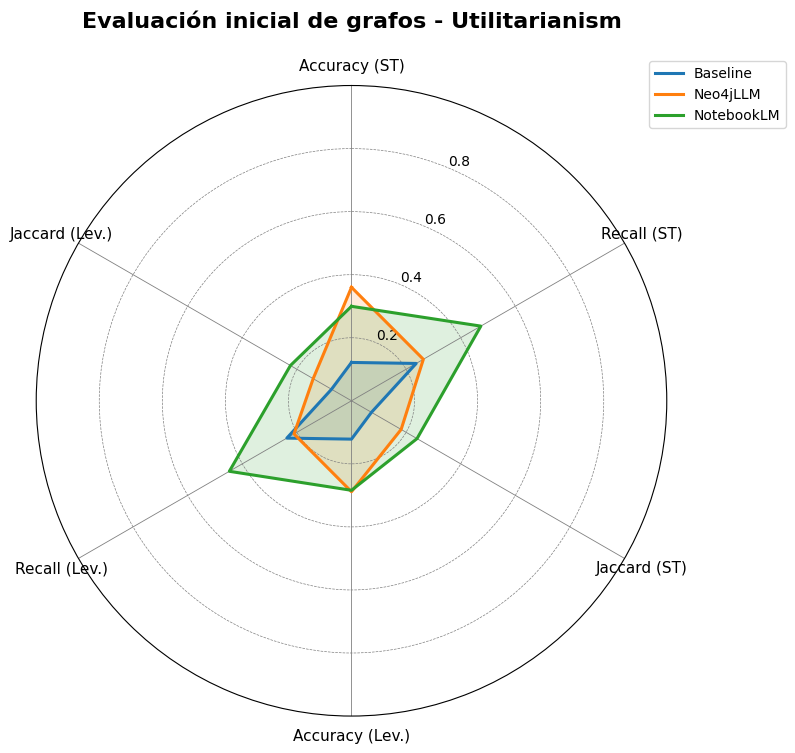

In [ ]:
plot_radar_chart(df_utilitarianism, title="Evaluación inicial de grafos - Utilitarianism")

In [ ]:
gold_path = "/content/Ellipse_Gold.csv"

versiones = [
    ("Baseline", "/content/Ellipse_Baseline.csv"),
    ("Neo4jLLM", "/content/Ellipse_Neo4jLLM.csv"),
    ("NotebookLM", "/content/Ellipse_NotebookLM.csv"),
]

In [ ]:
df_ellipse = pd.concat(
    [evaluar_grafo(gold_path, path, version_name) for version_name, path in versiones],
    ignore_index=True
)

df_ellipse

,versión,accuracy_ST,accuracy_Levenshtein,recall_ST,recall_Levenshtein,jaccard_ST,jaccard_Levenshtein
0,Baseline,0.114583,0.104167,0.275000,0.250000,0.089431,0.080645
1,Neo4jLLM,0.181818,0.181818,0.100000,0.100000,0.076923,0.076923
2,NotebookLM,0.233333,0.141457,0.380556,0.227778,0.189873,0.107143


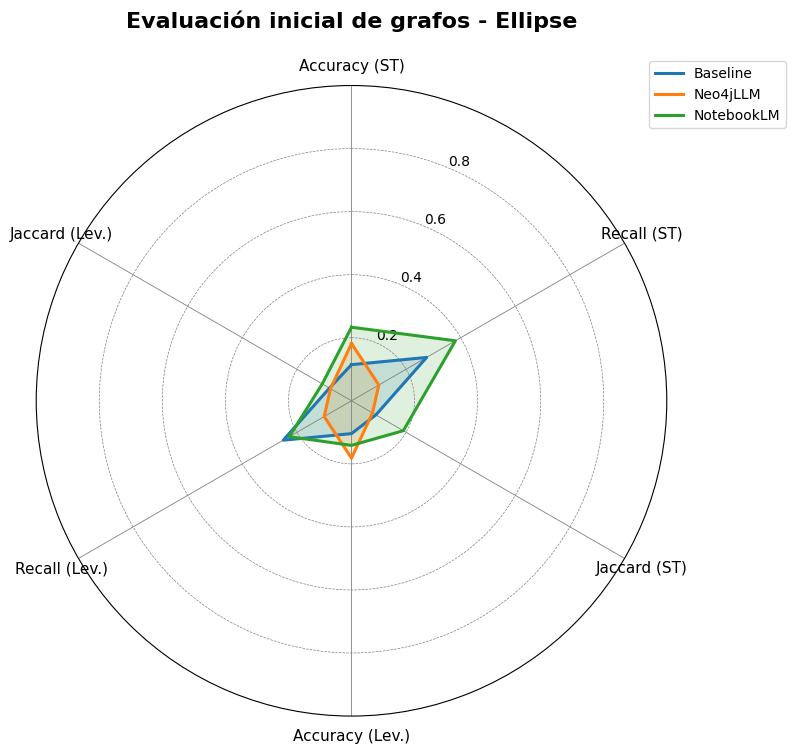

In [ ]:
plot_radar_chart(df_ellipse, title="Evaluación inicial de grafos - Ellipse")

In [ ]:
gold_path = "/content/Homeostasis_Gold.csv"

versiones = [
    ("Baseline", "/content/Homeostasis_Baseline.csv"),
    ("Neo4jLLM", "/content/Homeostasis_Neo4jLLM.csv"),
    ("NotebookLM", "/content/Homeostasis_NotebookLM.csv"),
]

In [ ]:
df_homeostasis = pd.concat(
    [evaluar_grafo(gold_path, path, version_name) for version_name, path in versiones],
    ignore_index=True
)

df_homeostasis

HTTP Error 429 thrown while requesting HEAD https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2/resolve/main/modules.json
Retrying in 1s [Retry 1/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2/resolve/main/modules.json
Retrying in 2s [Retry 2/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2/resolve/main/modules.json
Retrying in 4s [Retry 3/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2/resolve/main/modules.json
Retrying in 8s [Retry 4/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2/resolve/main/modules.json
Retrying in 8s [Retry 5/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2/resolve/main/modules.json
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/s

,versión,accuracy_ST,accuracy_Levenshtein,recall_ST,recall_Levenshtein,jaccard_ST,jaccard_Levenshtein
0,Baseline,0.148039,0.148039,0.135918,0.135918,0.073770,0.073770
1,Neo4jLLM,0.527412,0.527412,0.361408,0.361408,0.279070,0.279070
2,NotebookLM,0.281250,0.265625,0.272727,0.257576,0.168224,0.157407


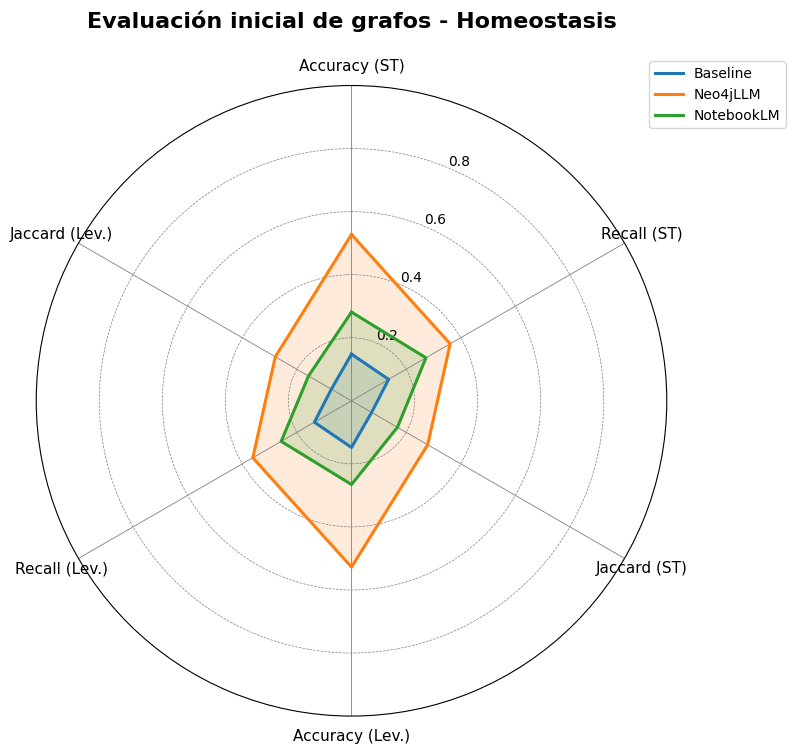

In [ ]:
plot_radar_chart(df_homeostasis, title="Evaluación inicial de grafos - Homeostasis")

In [ ]:
gold_path = "/content/Inflation_Gold.csv"

versiones = [
    ("Baseline", "/content/Inflation_Baseline.csv"),
    ("Neo4jLLM", "/content/Inflation_Neo4jLLM.csv"),
    ("NotebookLM", "/content/Inflation_NotebookLM.csv"),
]

In [ ]:
df_inflation = pd.concat(
    [evaluar_grafo(gold_path, path, version_name) for version_name, path in versiones],
    ignore_index=True
)

df_inflation

,versión,accuracy_ST,accuracy_Levenshtein,recall_ST,recall_Levenshtein,jaccard_ST,jaccard_Levenshtein
0,Baseline,0.074713,0.051724,0.203125,0.140625,0.051793,0.035294
1,Neo4jLLM,0.482692,0.361538,0.329545,0.240057,0.232323,0.161905
2,NotebookLM,0.256924,0.219919,0.440341,0.377841,0.197279,0.164474


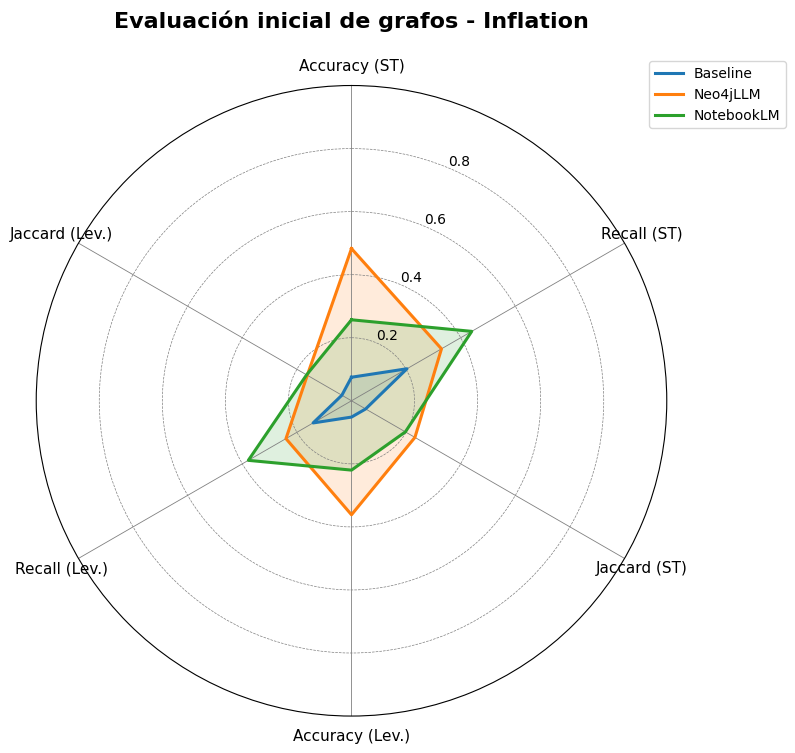

In [ ]:
plot_radar_chart(df_inflation, title="Evaluación inicial de grafos - Inflation")

## Evaluación final de grafos

In [ ]:
def plot_radar_chart(df, title="Evaluación de grafos", save_path=None):
    metrics = [
        "accuracy_ST",
        "recall_ST",
        "jaccard_ST",
        "accuracy_Levenshtein",
        "recall_Levenshtein",
        "jaccard_Levenshtein",
    ]

    labels = [
        "Accuracy (ST)",
        "Recall (ST)",
        "Jaccard (ST)",
        "Accuracy (Lev.)",
        "Recall (Lev.)",
        "Jaccard (Lev.)",
    ]

    num_vars = len(metrics)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

    plt.title(title, size=16, weight='bold', y=1.08)
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)

    ax.set_thetagrids(np.degrees(angles[:-1]), labels, fontsize=11)

    ax.set_ylim(0, 1)
    ax.yaxis.set_ticks([0.2, 0.4, 0.6, 0.8])
    ax.yaxis.set_ticklabels(["0.2", "0.4", "0.6", "0.8"], fontsize=10)
    ax.yaxis.grid(color="gray", linestyle="dashed", linewidth=0.5)
    ax.xaxis.grid(color="gray", linestyle="solid", linewidth=0.6)

    colors = ['#1f77b4', '#9467bd', '#ff7f0e', '#2ca02c', '#d62728', '#8c564b']
    for idx, row in df.iterrows():
        values = [row[m] for m in metrics]
        values += values[:1]
        label = row["versión"]
        color = colors[idx % len(colors)]
        ax.plot(angles, values, label=label, color=color, linewidth=2.2)
        ax.fill(angles, values, color=color, alpha=0.15)

    ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.05), fontsize=10)

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()

In [ ]:
gold_path = "/content/Utilitarianism_Gold.csv"

versiones = [
    ("Baseline", "/content/Utilitarianism_Baseline.csv"),
    ("Final", "/content/Utilitarianism_Final.csv"),
    ("Neo4jLLM", "/content/Utilitarianism_Neo4jLLM.csv"),
    ("NotebookLM", "/content/Utilitarianism_NotebookLM.csv"),
]

In [ ]:
df_utilitarianism = pd.concat(
    [evaluar_grafo(gold_path, path, version_name) for version_name, path in versiones],
    ignore_index=True
)

df_utilitarianism

,versión,accuracy_ST,accuracy_Levenshtein,recall_ST,recall_Levenshtein,jaccard_ST,jaccard_Levenshtein
0,Baseline,0.121622,0.121622,0.236842,0.236842,0.073171,0.073171
1,Final,0.189655,0.206897,0.289474,0.315789,0.139241,0.153846
2,Neo4jLLM,0.359890,0.288462,0.263158,0.210526,0.181818,0.140351
3,NotebookLM,0.299592,0.283967,0.473684,0.447368,0.240000,0.223684


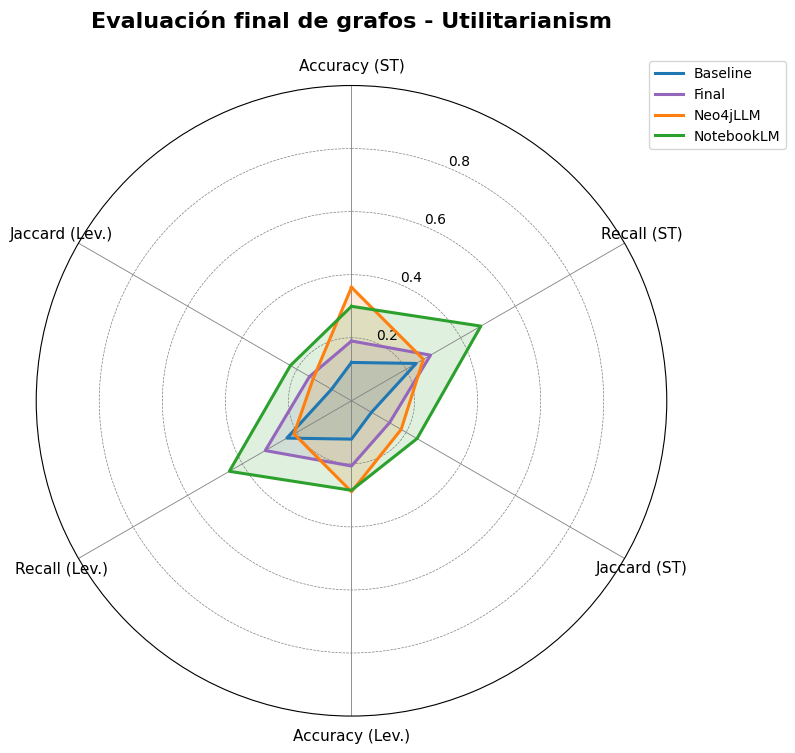

In [ ]:
plot_radar_chart(df_utilitarianism, title="Evaluación final de grafos - Utilitarianism")

In [ ]:
gold_path = "/content/Ellipse_Gold.csv"

versiones = [
    ("Baseline", "/content/Ellipse_Baseline.csv"),
    ("Final", "/content/Ellipse_Final.csv"),
    ("Neo4jLLM", "/content/Ellipse_Neo4jLLM.csv"),
    ("NotebookLM", "/content/Ellipse_NotebookLM.csv"),
]

In [ ]:
df_ellipse = pd.concat(
    [evaluar_grafo(gold_path, path, version_name) for version_name, path in versiones],
    ignore_index=True
)

df_ellipse

HTTP Error 429 thrown while requesting HEAD https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2/resolve/main/modules.json
Retrying in 1s [Retry 1/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2/resolve/main/modules.json
Retrying in 2s [Retry 2/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2/resolve/main/modules.json
Retrying in 4s [Retry 3/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2/resolve/main/modules.json
Retrying in 8s [Retry 4/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2/resolve/main/modules.json
Retrying in 8s [Retry 5/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2/resolve/main/modules.json
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/s

,versión,accuracy_ST,accuracy_Levenshtein,recall_ST,recall_Levenshtein,jaccard_ST,jaccard_Levenshtein
0,Baseline,0.114583,0.104167,0.275000,0.250000,0.089431,0.080645
1,Final,0.181818,0.130952,0.377778,0.275000,0.153061,0.107843
2,Neo4jLLM,0.181818,0.181818,0.100000,0.100000,0.076923,0.076923
3,NotebookLM,0.233333,0.141457,0.380556,0.227778,0.189873,0.107143


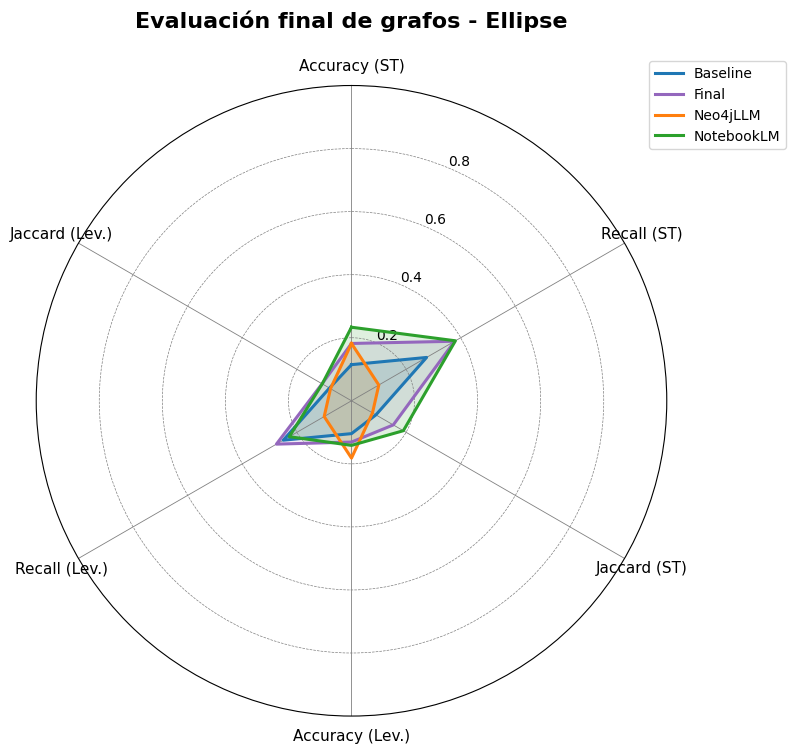

In [ ]:
plot_radar_chart(df_ellipse, title="Evaluación final de grafos - Ellipse")

In [ ]:
gold_path = "/content/Homeostasis_Gold.csv"

versiones = [
    ("Baseline", "/content/Homeostasis_Baseline.csv"),
    ("Final", "/content/Homeostasis_Final.csv"),
    ("Neo4jLLM", "/content/Homeostasis_Neo4jLLM.csv"),
    ("NotebookLM", "/content/Homeostasis_NotebookLM.csv"),
]

In [ ]:
df_homeostasis = pd.concat(
    [evaluar_grafo(gold_path, path, version_name) for version_name, path in versiones],
    ignore_index=True
)

df_homeostasis

,versión,accuracy_ST,accuracy_Levenshtein,recall_ST,recall_Levenshtein,jaccard_ST,jaccard_Levenshtein
0,Baseline,0.148039,0.148039,0.135918,0.135918,0.073770,0.073770
1,Final,0.198077,0.140385,0.151070,0.105615,0.097087,0.066038
2,Neo4jLLM,0.527412,0.527412,0.361408,0.361408,0.279070,0.279070
3,NotebookLM,0.281250,0.265625,0.272727,0.257576,0.168224,0.157407


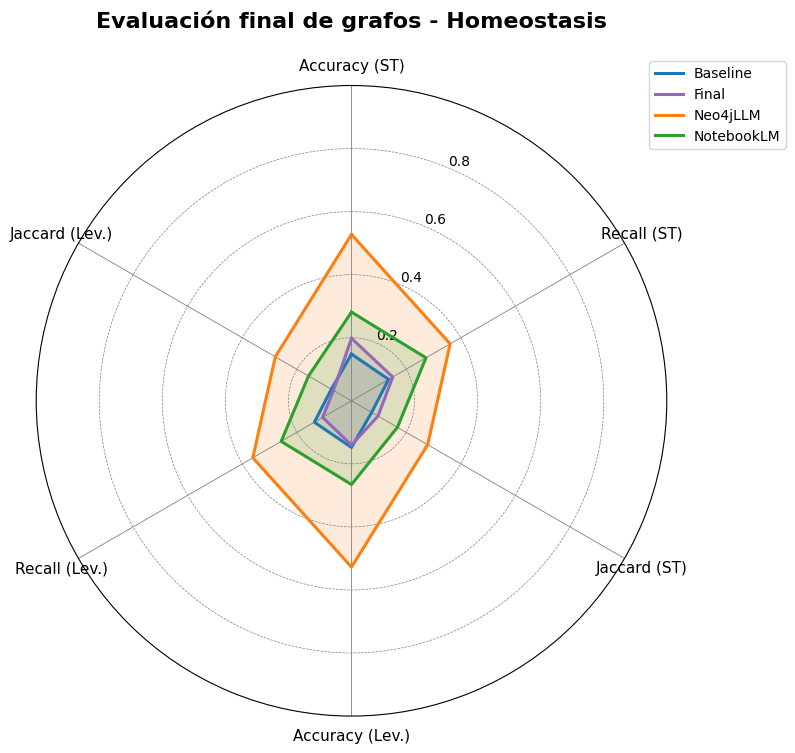

In [ ]:
plot_radar_chart(df_homeostasis, title="Evaluación final de grafos - Homeostasis")

In [ ]:
gold_path = "/content/Inflation_Gold.csv"

versiones = [
    ("Baseline", "/content/Inflation_Baseline.csv"),
    ("Final", "/content/Inflation_Final.csv"),
    ("Neo4jLLM", "/content/Inflation_Neo4jLLM.csv"),
    ("NotebookLM", "/content/Inflation_NotebookLM.csv"),
]

In [ ]:
df_inflation = pd.concat(
    [evaluar_grafo(gold_path, path, version_name) for version_name, path in versiones],
    ignore_index=True
)

df_inflation

HTTP Error 429 thrown while requesting HEAD https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2/resolve/main/modules.json
Retrying in 1s [Retry 1/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2/resolve/main/modules.json
Retrying in 2s [Retry 2/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2/resolve/main/modules.json
Retrying in 4s [Retry 3/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2/resolve/main/modules.json
Retrying in 8s [Retry 4/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2/resolve/main/modules.json
Retrying in 8s [Retry 5/5].
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2/resolve/main/modules.json
HTTP Error 429 thrown while requesting HEAD https://huggingface.co/s

,versión,accuracy_ST,accuracy_Levenshtein,recall_ST,recall_Levenshtein,jaccard_ST,jaccard_Levenshtein
0,Baseline,0.074713,0.051724,0.203125,0.140625,0.051793,0.035294
1,Final,0.147059,0.088235,0.234375,0.140625,0.098039,0.056604
2,Neo4jLLM,0.482692,0.361538,0.329545,0.240057,0.232323,0.161905
3,NotebookLM,0.256924,0.219919,0.440341,0.377841,0.197279,0.164474


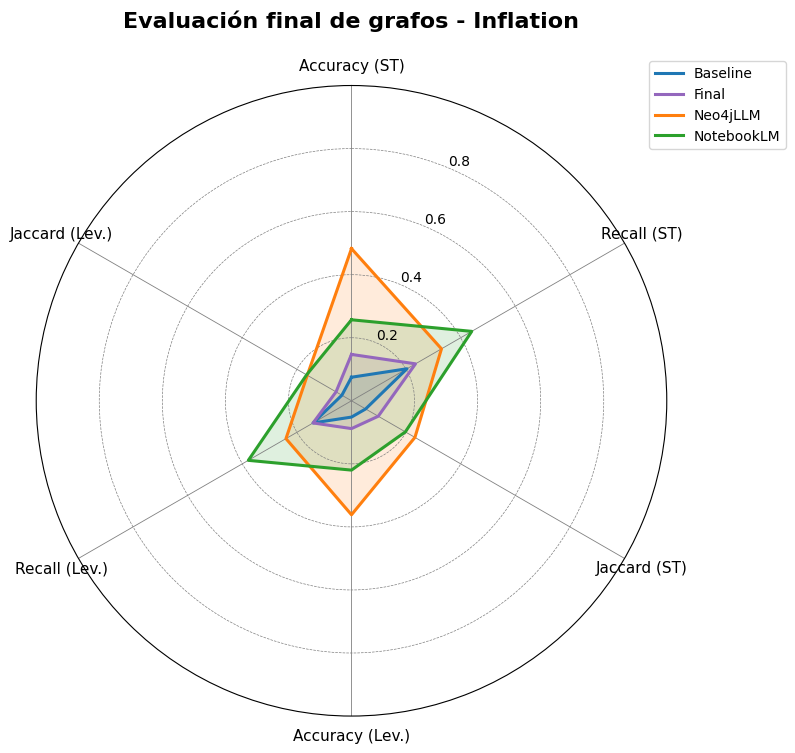

In [ ]:
plot_radar_chart(df_inflation, title="Evaluación final de grafos - Inflation")

      versión  accuracy_ST  accuracy_Levenshtein  recall_ST  \
0    Baseline     0.114739              0.106388   0.212721   
1       Final     0.179152              0.141617   0.263174   
2    Neo4jLLM     0.387953              0.339808   0.263528   
3  NotebookLM     0.267775              0.227742   0.391827   

   recall_Levenshtein  jaccard_ST  jaccard_Levenshtein  
0            0.190846    0.072041             0.065720  
1            0.209257    0.121857             0.096083  
2            0.227998    0.192534             0.164562  
3            0.327641    0.198844             0.163177  


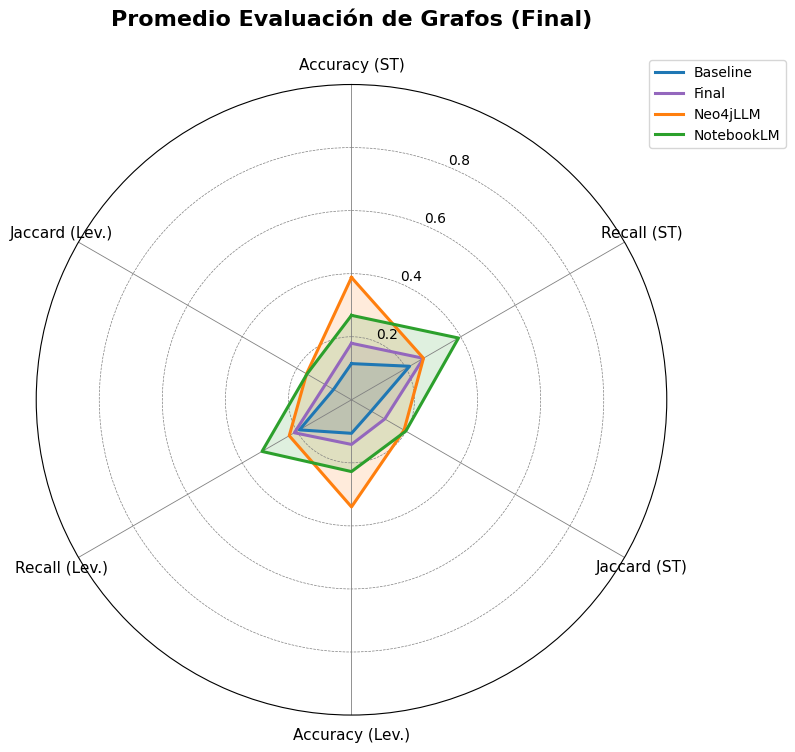

In [ ]:
# Unimos los DataFrames de las 4 temáticas
df_total = pd.concat([df_utilitarianism, df_ellipse, df_homeostasis, df_inflation])

# Calculamos el promedio por versión
df_promedios = df_total.groupby("versión", as_index=False).mean(numeric_only=True)

# Mostramos el DataFrame de promedios
print(df_promedios)

# Generamos el gráfico de radar con los promedios
plot_radar_chart(df_promedios, title="Promedio Evaluación de Grafos (Final)")
